In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

In [ ]:
#Import dataset

df = pd.read_csv('food_orders_new_delhi.csv')
df.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


In [ ]:
#Filter features

df_features = df[['Customer ID','Order Value', 'Commission Fee']].set_index('Customer ID')
df_features.head()

,Order Value,Commission Fee
Customer ID,,
C8270,1914,150
C1860,986,198
C6390,937,195
C6191,1463,146
C6734,1992,130


In [ ]:
#Remove outlier

def outlier_remove (df, weight = 1.5):

    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)

    iqr = q3 - q1
    iqr_weight = iqr * weight

    range_min = q1 - iqr_weight
    range_max = q3 + iqr_weight

    outlier_per_col = (df < range_min) | (df > range_max)

    is_outlier = outlier_per_col.any(axis = 1)

    return is_outlier

In [ ]:
df_outlier = outlier_remove (df_features, weight = 1.5) #outlier data
df_features = df_features[~df_outlier]
df_features.head()

,Order Value,Commission Fee
Customer ID,,
C8270,1914,150
C1860,986,198
C6390,937,195
C6191,1463,146
C6734,1992,130


In [ ]:
#Normarize data

df_features_mean = df_features.mean()
df_features_std = df_features.std()

df_norm = (df_features - df_features_mean) / df_features_std
df_norm.head()

,Order Value,Commission Fee
Customer ID,,
C8270,1.619719,0.534320
C1860,-0.128008,1.648939
C6390,-0.220291,1.579276
C6191,0.770339,0.441435
C6734,1.766619,0.069896


<Axes: xlabel='Order Value', ylabel='Commission Fee'>

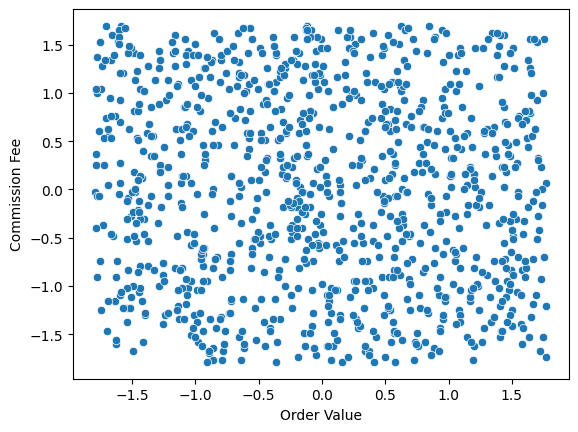

In [ ]:
#Visualize data

sns.scatterplot(data = df_norm, x = df_norm['Order Value'], y = df_norm['Commission Fee'])

In [ ]:
#Visualize inertias (distance between centers and data)

inertias = [] #intertia 저장 리스트

for k in range (1, 16):
    model = KMeans(n_clusters = k, random_state = 123)
    model.fit(df_norm)
    inertias.append(model.inertia_)

<Axes: >

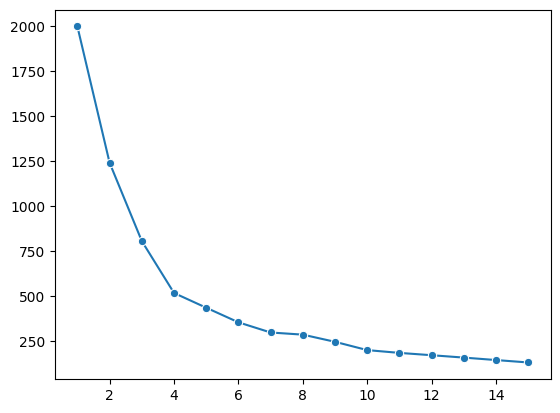

In [ ]:
sns.lineplot(x = range(1, 16), y = inertias, marker = 'o')

In [ ]:
#Develop a KMeans model (k = 5)

model = KMeans(n_clusters = 5, random_state = 123)
model.fit(df_norm)

KMeans(n_clusters=5, random_state=123)

In [ ]:
#Separate customers in groups

df_features['label'] = model.predict(df_norm)
df_features

,Order Value,Commission Fee,label
Customer ID,,,
C8270,1914,150,2
C1860,986,198,4
C6390,937,195,4
C6191,1463,146,2
C6734,1992,130,2
...,...,...,...
C6232,825,165,4
C6797,1627,110,1
C5926,553,64,3


<Axes: xlabel='Order Value', ylabel='Commission Fee'>

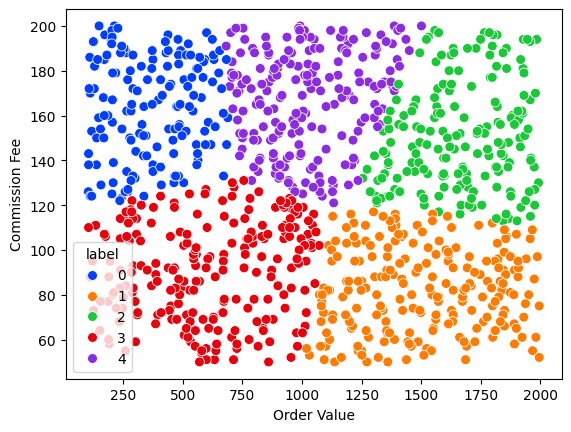

In [ ]:
#Visualize the groups

sns.scatterplot(x = df_features['Order Value'], y = df_features['Commission Fee'], hue = df_features['label'], s = 50, palette = 'bright')

In [ ]:
#Count total customer per each group

pd.DataFrame(df_features['label'].value_counts())

,count
label,
3,229
1,223
4,208
2,184
0,156


In [ ]:
#Calculate average features per group

groupby_df = df_features.groupby('label').mean()
groupby_df

,Order Value,Commission Fee
label,,
0,376.237179,163.102564
1,1499.717489,81.739910
2,1665.010870,150.918478
3,617.336245,90.903930
4,1024.552885,166.980769


In [ ]:
#Calculate average profit per group

groupby_df['Profit Mean'] = groupby_df['Order Value'] + groupby_df['Commission Fee']
groupby_df

,Order Value,Commission Fee,Profit Mean
label,,,
0,376.237179,163.102564,539.339744
1,1499.717489,81.739910,1581.457399
2,1665.010870,150.918478,1815.929348
3,617.336245,90.903930,708.240175
4,1024.552885,166.980769,1191.533654


In [ ]:
#Change feature names

groupby_df = groupby_df.rename(columns = {'Order Value' : 'Order Value Mean', 'Commission Fee' : 'Commission Fee Mean'})
groupby_df

,Order Value Mean,Commission Fee Mean,Profit Mean
label,,,
0,376.237179,163.102564,539.339744
1,1499.717489,81.739910,1581.457399
2,1665.010870,150.918478,1815.929348
3,617.336245,90.903930,708.240175
4,1024.552885,166.980769,1191.533654


In [ ]:
#Listup customers in the most profitable group

label_2 = df_features['label'] == 2

df_features[label_2]

,Order Value,Commission Fee,label
Customer ID,,,
C8270,1914,150,2
C6191,1463,146,2
C6734,1992,130,2
C6578,1663,116,2
C5555,1798,191,2
...,...,...,...
C9533,1864,137,2
C7704,1335,132,2
C5524,1524,147,2


In [ ]:
#Listup the least profitable group

label_0 = df_features['label'] == 0

df_features[label_0]

,Order Value,Commission Fee,label
Customer ID,,,
C1466,303,144,0
C9322,491,189,0
C7420,504,130,0
C4005,155,151,0
C4890,203,125,0
...,...,...,...
C6031,470,133,0
C3708,202,192,0
C9666,671,133,0
